## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [7]:
# Check the GPU
!nvidia-smi

Fri Apr  4 15:17:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [9]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [10]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2025-04-04 15:21:24--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84961 (83K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.97K  --.-KB/s    in 0.01s   

2025-04-04 15:21:24 (5.60 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84961/84961]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
upload the file through the cell below, or upload them manually to specified directory.



In [11]:
import os

local_dir = "./cher/content/lola" #@param
os.makedirs(local_dir,exist_ok=True)

**Upload** example images from your local files. You can also upload your images manually to the speficied folder.

In [13]:
from google.colab import files

# pick a name for the image folder
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

Saving  .jpeg to  .jpeg
Saving 1200-Ayla-lola-dupre.jpeg to 1200-Ayla-lola-dupre.jpeg
Saving 1200-Fluffy-lola-dupre.jpeg to 1200-Fluffy-lola-dupre.jpeg
Saving 1200-Nibbler-Lola-Dupre.jpeg to 1200-Nibbler-Lola-Dupre.jpeg
Saving 1200-tall-coby-lola-dupre.jpeg to 1200-tall-coby-lola-dupre.jpeg
Saving 1200-the-unknown-cat-lola-dupre.jpeg to 1200-the-unknown-cat-lola-dupre.jpeg
Saving 1600-bampot-detail-2-lola-dupre.jpeg to 1600-bampot-detail-2-lola-dupre.jpeg
Saving 1900-snowball-lola-dupre.jpeg to 1900-snowball-lola-dupre.jpeg
Saving 1920-andromeda-lola-dupre.jpeg to 1920-andromeda-lola-dupre.jpeg
Saving 1920-argus-lola-dupre.jpeg to 1920-argus-lola-dupre.jpeg
Saving 1920-atlas-lola-dupre.jpeg to 1920-atlas-lola-dupre.jpeg
Saving 1920-biscuits-lola-dupre.jpeg to 1920-biscuits-lola-dupre.jpeg
Saving 1920-buttons-lola-dupre.jpeg to 1920-buttons-lola-dupre.jpeg
Saving 1920-cat-with-nyt-october-29th--loladupre.jpeg to 1920-cat-with-nyt-october-29th--loladupre.jpeg
Saving 1920-Dudley-lola-dupr

Preview the images:

In [14]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [16]:
import glob

# change path to display images from your local dir
img_paths = "./cher/content/lola.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

IndexError: list index out of range

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [17]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [18]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./cher/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [19]:
import json

caption_prefix = "photo collage in LOLA style, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

In [5]:
!cat cher/metadata.jsonl

cat: cher/metadata.jsonl: No such file or directory


Free some memory:

In [20]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [21]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [23]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [37]:
!pip install datasets -q

In [ ]:
#урааааа загрузилось

In [34]:
#да что вы издеваетесь с этими разными версиями
!pip uninstall -y fsspec gcsfs


Found existing installation: fsspec 2024.12.0
Uninstalling fsspec-2024.12.0:
  Successfully uninstalled fsspec-2024.12.0
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2


In [35]:
!pip install fsspec==2024.12.0 gcsfs==2024.12.0

  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)


In [36]:
!pip list | grep "fsspec\|gcsfs"


fsspec                             2024.12.0
gcsfs                              2024.12.0


In [30]:
!pip list | grep "fsspec\|gcsfs"


fsspec                             2024.12.0
gcsfs                              2025.3.2


In [31]:
!pip uninstall -y fsspec gcsfs
!pip install fsspec==2025.3.2 gcsfs==2025.3.2


Found existing installation: fsspec 2024.12.0
Uninstalling fsspec-2024.12.0:
  Successfully uninstalled fsspec-2024.12.0
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached gcsfs-2025.3.2-py2.py3-none-any.whl.metadata (1.9 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached gcsfs-2025.3.2-py2.py3-none-any.whl (36 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.


In [32]:
!pip list | grep "fsspec\|gcsfs"


fsspec                             2025.3.2
gcsfs                              2025.3.2


In [28]:
!pip uninstall -y fsspec gcsfs
!pip install fsspec==2025.3.2 gcsfs


Found existing installation: fsspec 2024.12.0
Uninstalling fsspec-2024.12.0:
  Successfully uninstalled fsspec-2024.12.0
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.


In [25]:
!pip install fsspec==2025.3.2 --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.


In [26]:
!pip install --upgrade gcsfs


In [1]:
#решаю ошибки с копиями разных библиотек
!pip install --upgrade pip setuptools

!pip install --no-deps --force-reinstall datasets

!pip install -U fsspec==2025.3.2 torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 3.5.0
    Uninstalling datasets-3.5.0:
      Successfully uninstalled datasets-3.5.0
Looking in indexes: https://download.pytorch.org/whl/cu121
ERROR: Could not find a version that satisfies the requirement fsspec==2025.3.2 (from versions: 2023.4.0, 2024.2.0, 2024.6.1)
ERROR: No matching distribution found for fsspec==2025.3.2


In [14]:
!pip install --upgrade fsspec


  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.


In [15]:
!pip uninstall -y gcsfs
!pip install --no-cache-dir gcsfs


Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2


In [16]:
!pip install datasets


  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [17]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (780.5 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (3.4 MB)


In [18]:
!pip install datasets


In [8]:
import datasets
print(datasets.__version__)


3.5.0


 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [38]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="cher" \
  --output_dir="cherakshin_style_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="photo collage in CHERKASHIN style" \
  --resolution=512 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=250 \
  --seed="0"

2025-04-04 15:31:56.431537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743780716.468775    6661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743780716.482372    6661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
04/04/2025 15:32:01 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer_config.json: 100% 737/737 [00:00<00:00, 3.75MB/s]
vocab.json: 100% 1.06M/1.06M [00:00<00:00, 23.4MB/s]
merges.txt: 100% 525k/525k [00:00<00:00, 2.94MB/s]
special_tokens_map.json: 100% 472/472 [00:00<00:00, 2.00MB/s]
tokenizer_config.json: 100% 

In [10]:
!ls cherakshin_style_LoRA

ls: cannot access 'cherakshin_style_LoRA': No such file or directory


### Save your model to the hub and check it out 🔥

In [30]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "cherakshin_style_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [31]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="photo collage in CHERKASHIN style",
    validation_prompt=None,
    repo_folder=output_dir,
    use_dora = False,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

ModuleNotFoundError: No module named 'train_dreambooth_lora_sdxl'

In [24]:
!find / -name "train_dreambooth_lora_sdxl.py" 2>/dev/null


In [27]:
!find / -name "train_dreambooth_lora_sdxl.py" 2>/dev/null


In [28]:
!pwd


/content


In [29]:
cd /content  # укажите путь, где находится файл


[Errno 2] No such file or directory: '/content # укажите путь, где находится файл'
/content


In [25]:
import sys
sys.path.append('/content/dreambooth')  # замените на реальный путь
from train_dreambooth_lora_sdxl import save_model_card


ModuleNotFoundError: No module named 'train_dreambooth_lora_sdxl'

In [26]:
!git clone https://github.com/username/repository.git
cd repository
!pip install -e .


SyntaxError: invalid syntax (<ipython-input-26-4d9e9e66cc06>, line 2)

In [20]:
!pip install train_dreambooth_lora_sdxl


ERROR: Could not find a version that satisfies the requirement train_dreambooth_lora_sdxl (from versions: none)
ERROR: No matching distribution found for train_dreambooth_lora_sdxl


In [24]:
!ls


sample_data


In [21]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/marressi/cherakshin_style_LoRA

Let's generate some images with it!

## Inference 🐕

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

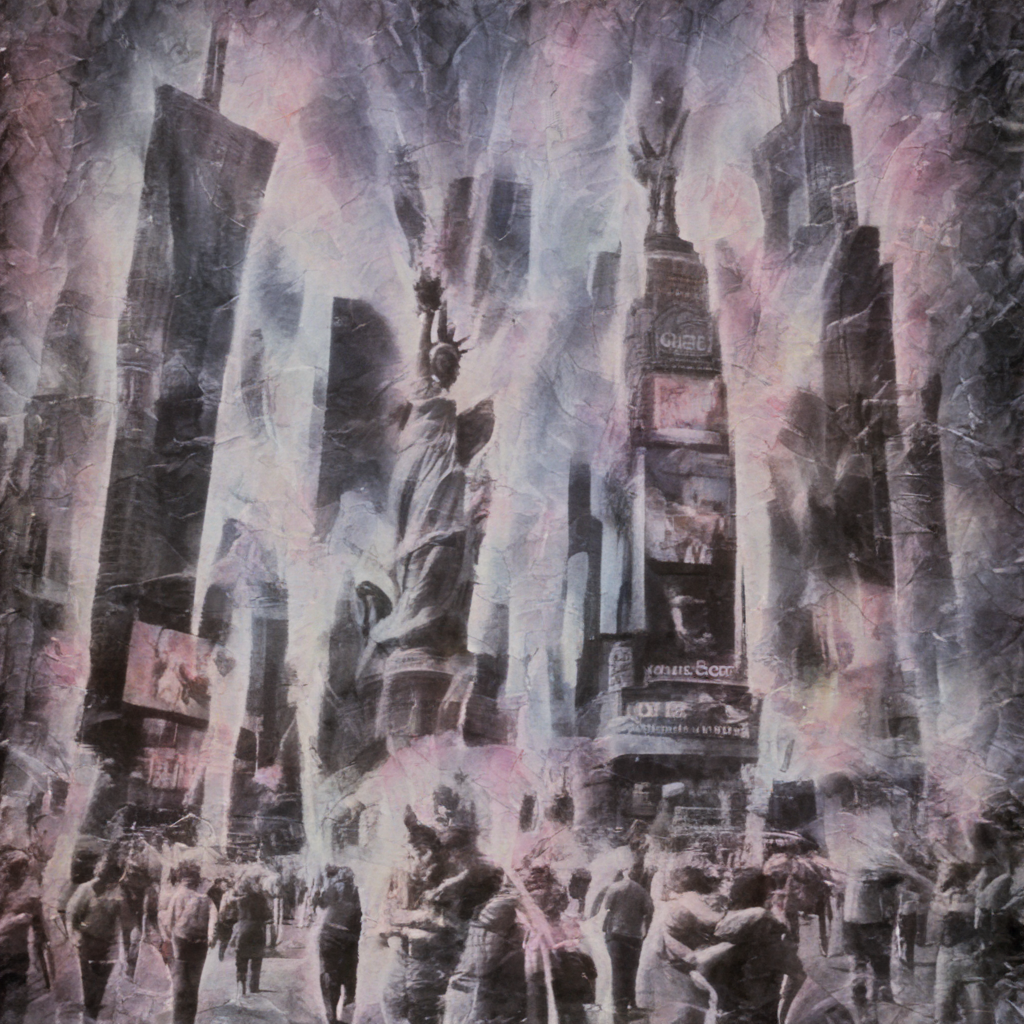

In [ ]:
prompt = "photo collage in CHERKASHIN style, times square, new york" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

In [ ]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights("cherakshin_style_LoRA/checkpoint-250")
pipe.fuse_lora(lora_scale=0.5)
_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

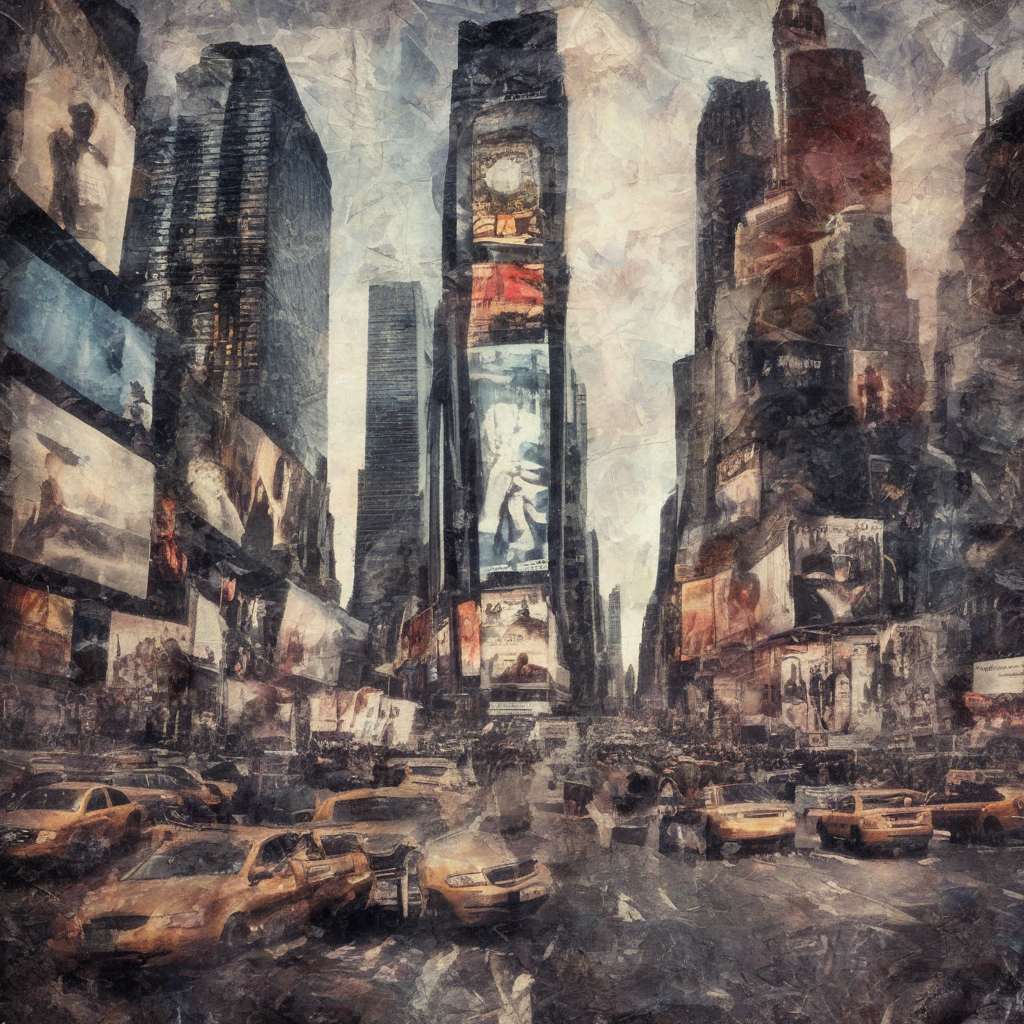

In [ ]:
prompt = "photo collage in CHERKASHIN style, times square, new york" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image